<a href="https://colab.research.google.com/github/KostaKat/Fire-Mask-Prediction/blob/package/notebooks/data_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
from typing import Dict, List, Optional, Tuple
from typing_extensions import Text
import tensorflow as tf
import re
import sys
sys.path.append('/home/kosta/Fire-Mask-Prediction')
from data_utils import *
from data_utils.data_cons import INPUT_FEATURES, OUTPUT_FEATURES, TITLES
from data_utils.parse_files import get_dataset
from data_utils.augs import random_crop_input_and_output_images

2024-11-20 16:37:36.241173: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 16:37:36.248405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732145856.256460   17021 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732145856.258776   17021 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 16:37:36.267021: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors

BATCH_SIZE = 32

# Define the dataset
dataset = get_dataset(
    '/mnt/c/Users/kosta/Downloads/archive (1)/next_day_wildfire_spread_test*',
    data_size=64,
    sample_size=64,
    batch_size=BATCH_SIZE,
    num_in_channels=12,
    compression_type=None,
    clip_and_normalize=True,
    clip_and_rescale=False,
    random_crop=True,
    center_crop=False
)

# Iterate through the dataset to check the shape of the labels
for inputs, labels in dataset.take(1):  # Only take one batch for inspection
    print("Inputs shape:", inputs.shape)  # Shape of inputs
    print("Labels shape:", labels.shape)  # Shape of labels

    # Extract the number of channels in the labels
    num_channels = labels.shape[-1]
    print(f"Number of channels in each label: {num_channels}")

    # Optionally, print the shape of individual images
    for i, label in enumerate(labels):
        print(f"Shape of label {i}: {label.shape}")
   
 


I0000 00:00:1732145858.380958   17021 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13126 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9


Inputs shape: (32, 64, 64, 12)
Labels shape: (32, 64, 64, 1)
Number of channels in each label: 1
Shape of label 0: (64, 64, 1)
Shape of label 1: (64, 64, 1)
Shape of label 2: (64, 64, 1)
Shape of label 3: (64, 64, 1)
Shape of label 4: (64, 64, 1)
Shape of label 5: (64, 64, 1)
Shape of label 6: (64, 64, 1)
Shape of label 7: (64, 64, 1)
Shape of label 8: (64, 64, 1)
Shape of label 9: (64, 64, 1)
Shape of label 10: (64, 64, 1)
Shape of label 11: (64, 64, 1)
Shape of label 12: (64, 64, 1)
Shape of label 13: (64, 64, 1)
Shape of label 14: (64, 64, 1)
Shape of label 15: (64, 64, 1)
Shape of label 16: (64, 64, 1)
Shape of label 17: (64, 64, 1)
Shape of label 18: (64, 64, 1)
Shape of label 19: (64, 64, 1)
Shape of label 20: (64, 64, 1)
Shape of label 21: (64, 64, 1)
Shape of label 22: (64, 64, 1)
Shape of label 23: (64, 64, 1)
Shape of label 24: (64, 64, 1)
Shape of label 25: (64, 64, 1)
Shape of label 26: (64, 64, 1)
Shape of label 27: (64, 64, 1)
Shape of label 28: (64, 64, 1)
Shape of label

2024-11-20 16:38:01.055114: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
2024-11-20 16:38:01.094914: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#Plot dataset

In [3]:
def plot_samples_from_dataset(dataset: tf.data.Dataset, n_rows: int):
    """
    Plot 'n_rows' rows of samples from dataset.

    Args:
        dataset (Dataset): Dataset from which to plot samples.
        n_rows (int): Number of rows to plot.
    """
    global TITLES

    # Get batch
    inputs, labels = None, None
    for elem in dataset:
        inputs, labels = elem
        break
    # Check the shape of the inputs
    print("Shape of inputs:", inputs.shape)
    print("Number of channels in the inputs:", inputs.shape[-1])
    fig = plt.figure(figsize=(15,6.5))

    # Variables for controllong the color map for the fire masks
    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
    # Number of data variables
    n_features = 12
    for i in range(n_rows):
        for j in range(n_features + 1):
            plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
            if i == 0:
                plt.title(TITLES[j], fontsize=13)
            if j < n_features - 1:
                plt.imshow(inputs[i, :, :, j])
            if j == n_features - 1:
                plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
            if j == n_features:
                plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM)
            plt.axis('off')
    plt.tight_layout()


Shape of inputs: (32, 64, 64, 12)
Number of channels in the inputs: 12


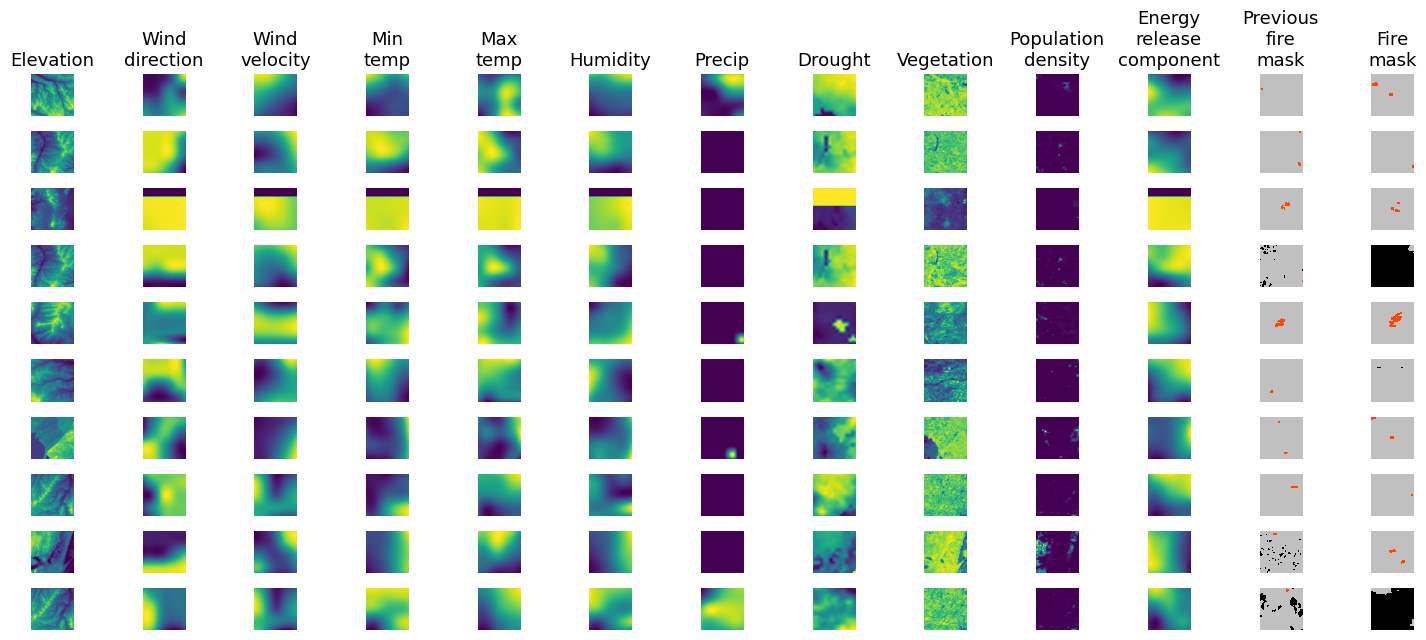

In [4]:
plot_samples_from_dataset(dataset, 10) #n_rows = 5